## Data reading and Data Insights

**Readin a Book Participant: ocnaab1f, 16 days participation**

*Dataset:* 'Reading a book' vs 'Avoid reading a book' study




#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.scan import scan

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_reading_books_-_ocnaab1f_2025-05-11 23_12_05.590//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_reading_books_-_ocnaab1f_2025-05-11 23_12_05.590//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: ocnaab1f
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [3]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has only one unique value: 'efdd019d-8a46-4ab2-87f5-4fb9e8eecbc4'


#### Participation of the study

In [4]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  efdd019d-8a46-4ab2-87f5-4fb9e8eecbc4                  15


As anticipated, the study comprised a single participant, with a total participation period of 16 days.

#### Missing Values

In [5]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=16, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),           
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)



--- Participant efdd019d-8a46-4ab2-87f5-4fb9e8eecbc4 ---

  Outcome:
    Start date:           2025-04-24
    End of expected 16d:  2025-05-09
    Expected days count:  16
    Completed days count: 15
    Missed days count:    1
    Missed dates:
       2025-05-02

  Mediators:
    Start date:           2025-04-24
    End of expected 16d:  2025-05-09
    Expected days count:  16
    Completed days count: 14
    Missed days count:    2
    Missed dates:
       2025-05-01
       2025-05-02


#### Remove Participants Who Joined Outside the Study

In [6]:
# df_mea = df_mea[df_mea['participant_id'] != "ca773388-eb42-4716-995a-476ed72c0475"]
# df_mea.shape[0]

#### Data Preperation

In [7]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(1)

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-05-09 20:30:17.652117+00:00,Mediators,efdd019d-8a46-4ab2-87f5-4fb9e8eecbc4,15,Reading books!,NaN,NaN,NaN,NaN,2.0,3.0


In [8]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [9]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [10]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
28,2025-04-24 19:46:23.710040+00:00,Outcome,efdd019d-8a46-4ab2-87f5-4fb9e8eecbc4,0,Reading books!,3.0,2.0,6.0,1.0,NaN,NaN
26,2025-04-25 20:03:46.986421+00:00,Outcome,efdd019d-8a46-4ab2-87f5-4fb9e8eecbc4,1,Reading books!,3.0,2.0,6.0,1.0,NaN,NaN
24,2025-04-26 20:23:00.977259+00:00,Outcome,efdd019d-8a46-4ab2-87f5-4fb9e8eecbc4,2,Reading books!,4.0,3.0,8.0,1.0,NaN,NaN
22,2025-04-27 19:55:38.508023+00:00,Outcome,efdd019d-8a46-4ab2-87f5-4fb9e8eecbc4,3,Reading books!,6.0,5.0,8.0,1.0,NaN,NaN
20,2025-04-28 18:00:49.959757+00:00,Outcome,efdd019d-8a46-4ab2-87f5-4fb9e8eecbc4,4,Not reading books!,7.0,8.0,1.0,8.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)    

#### Data Shape

In [11]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 15
Columns: 11


#### Data Types of columns

In [12]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [13]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:
        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=16, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),      
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant efdd019d-8a46-4ab2-87f5-4fb9e8eecbc4 ---

  Outcome:
    Start date:           2025-04-24
    End of expected 16d:  2025-05-09
    Expected days count:  16
    Completed days count: 15
    Missed days count:    1
    Missed dates:
       2025-05-02

  Mediators:
    Start date:           2025-04-24
    End of expected 16d:  2025-05-09
    Expected days count:  16
    Completed days count: 14
    Missed days count:    2
    Missed dates:
       2025-05-01
       2025-05-02

  survey1_question1_response:
    Start date:           2025-04-24
    End of expected 16d:  2025-05-09
    Expected days count:  16
    Completed days count: 15
    Missed days count:    1
    Missed dates:
       2025-05-02

  survey1_question2_response:
    Start date:           2025-04-24
    End of expected 16d:  2025-05-09
    Expected days count:  16
    Completed days count: 15
    Missed days count:    1
    Missed dates:
       2025-05-02

  survey1_question3_response:
    Start date:      

#### Missing Values for Confirmations between 08.00 - 21.00

In [14]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=16, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 16 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

All 16 days have participation confirmations; no missing days found.


#### Summary Statistics

In [15]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             15.000000                   15.000000   
mean               7.466667                    4.333333   
std                4.926121                    1.838737   
min                0.000000                    2.000000   
25%                3.500000                    3.000000   
50%                7.000000                    4.000000   
75%               11.500000                    6.000000   
max               15.000000                    8.000000   

       survey1_question2_response  survey1_question3_response  \
count                   15.000000                   15.000000   
mean                     3.733333                    3.933333   
std                      1.667619                    2.939064   
min                      2.000000                    1.000000   
25%                      3.000000                    1.000000   
50%                      3.000000               

In [16]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 28 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            15 non-null     datetime64[ns, UTC]
 1   measurement_name            15 non-null     object             
 2   participant_id              15 non-null     object             
 3   current_day_of_study        15 non-null     int64              
 4   current_intervention_name   15 non-null     object             
 5   survey1_question1_response  15 non-null     float64            
 6   survey1_question2_response  15 non-null     float64            
 7   survey1_question3_response  15 non-null     float64            
 8   survey1_question4_response  15 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

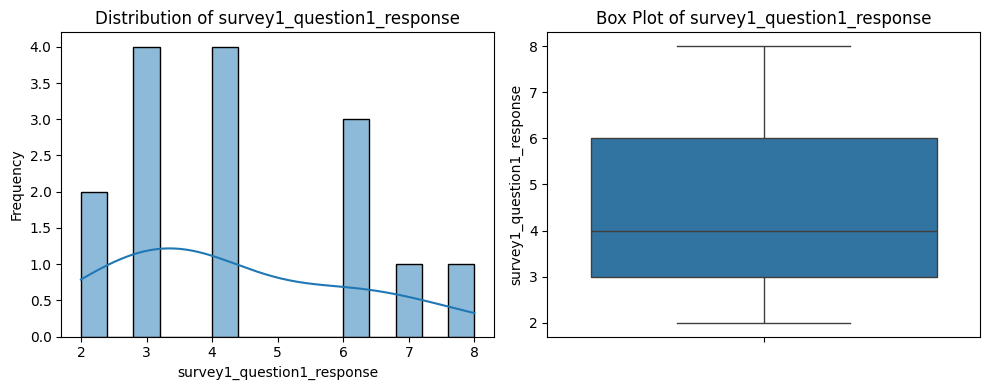

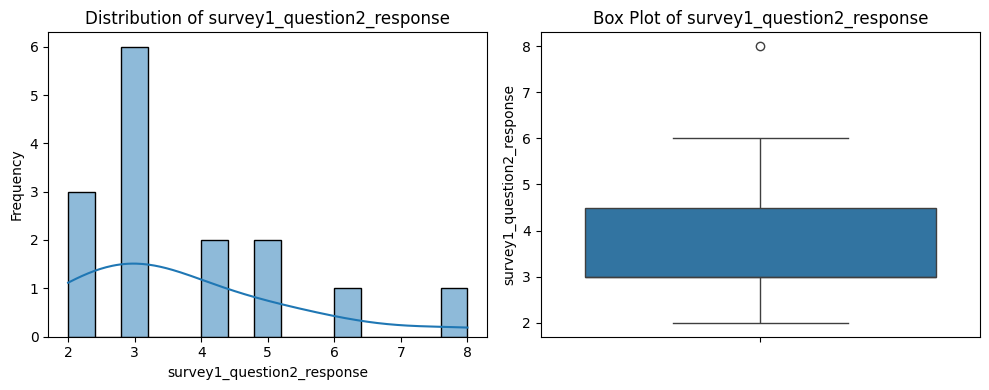

In [17]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']

for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

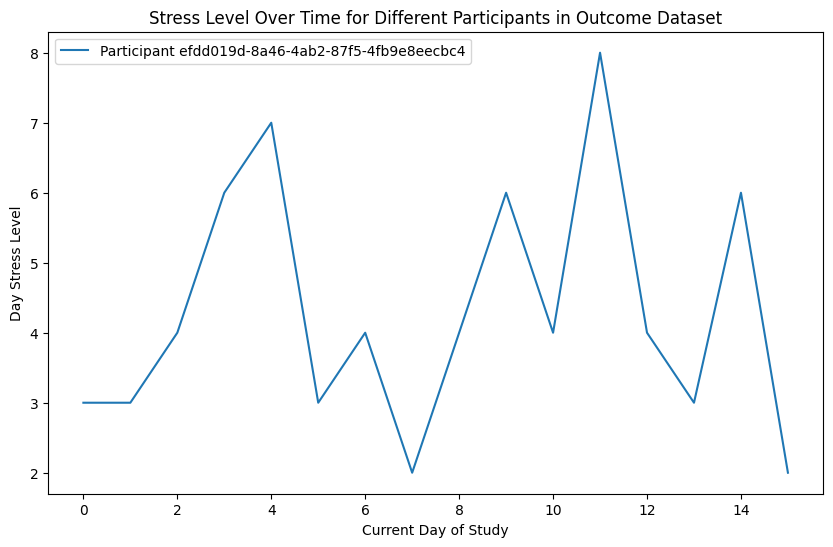

In [18]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6)) 

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Different Participants in Outcome Dataset')

plt.legend()
plt.show()

#### Scatterplot

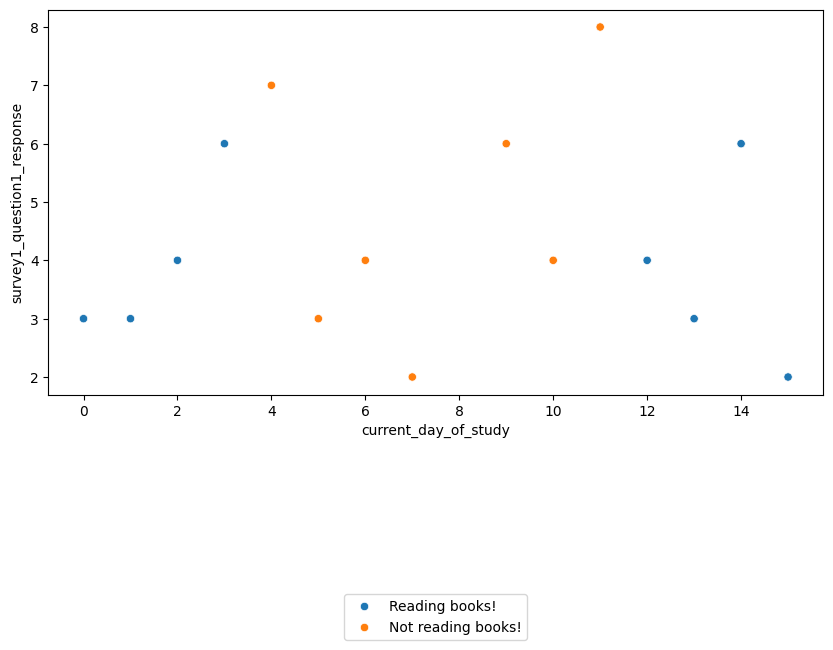

In [19]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))


#### Correlations

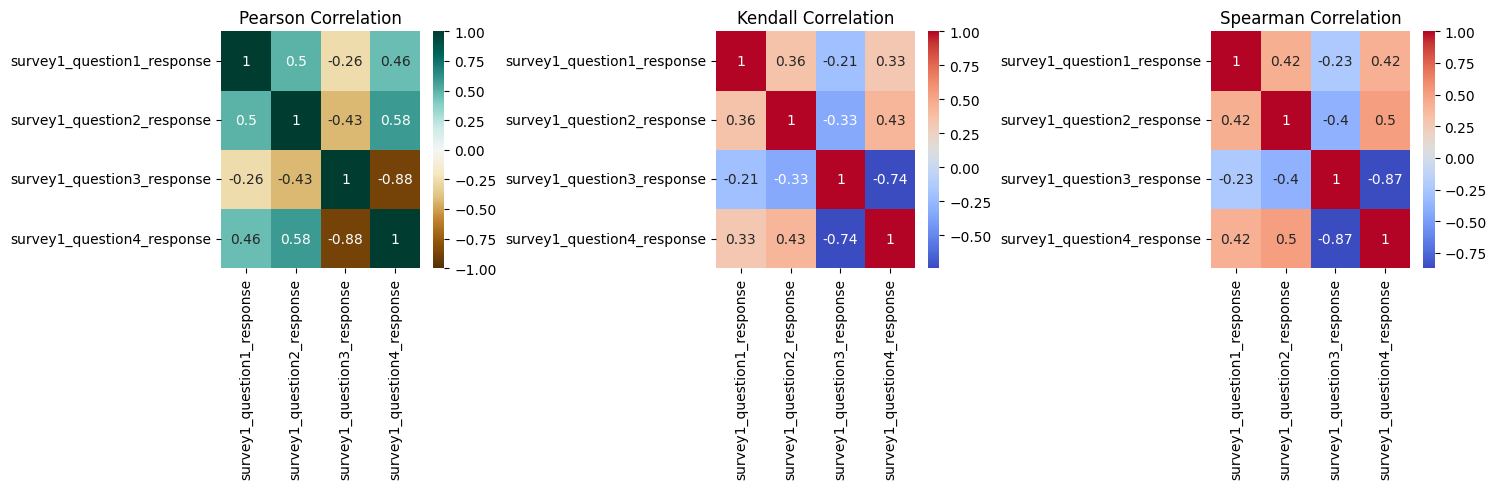

In [20]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Reading books! vs Not Reading books!

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)
        - Bayesian AR(1) Regression with Consecutive‐Day Adjustment
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Mean Imputation Method
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Latent Variable Method

#### Examination of Outcomes: Today Stress Level

In [21]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Reading books!",
        "Not reading books!"
    ])
]

reading = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Reading books!",
    'survey1_question1_response'
]
avoid_reading = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not reading books!",
    'survey1_question1_response'
]

n_reading         = reading.count()
n_avoid_reading   = avoid_reading.count()
std_reading       = reading.std(ddof=1)
std_avoid_reading = avoid_reading.std(ddof=1)

print(f"Reading book:          n = {n_reading}, std = {std_reading:.2f}, mean = {reading.mean():.2f}")
print(f"Not reading book:      n = {n_avoid_reading}, std = {std_avoid_reading:.2f}, mean = {avoid_reading.mean():.2f}\n")

Reading book:          n = 8, std = 1.46, mean = 3.88
Not reading book:      n = 7, std = 2.19, mean = 4.86



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [22]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Reading books!",
        "Not reading books!"
    ])
]

reading = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Reading books!",
    'survey1_question2_response'
]
avoid_reading = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not reading books!",
    'survey1_question2_response'
]

n_reading         = reading.count()
n_avoid_reading   = avoid_reading.count()
std_reading       = reading.std(ddof=1)
std_avoid_reading = avoid_reading.std(ddof=1)

print(f"Reading book:          n = {n_reading}, std = {std_reading:.2f}, mean = {reading.mean():.2f}")
print(f"Not reading book:      n = {n_avoid_reading}, std = {std_avoid_reading:.2f}, mean = {avoid_reading.mean():.2f}\n")


Reading book:          n = 8, std = 1.07, mean = 3.00
Not reading book:      n = 7, std = 1.90, mean = 4.57



#### Examination of Outcomes: Mean Stress-Relief Score for Reading a Book (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much reading a book alleviated participants’ stress on days they performed.

In [23]:
df_mea.survey1_question3_text[0]

"Did your miracle stress-shrinking method (<i>reading a book</i>) help you feel like a calm, happy puppy or was it more like trying to train a cat to do your taxes? <b>(1 = Not helpful at all to 10 = I'm practically levitating with calmness) <i>(Answer ONLY if you have read a book!)</i></b>\n"

In [24]:
# "Did your miracle stress-shrinking method (reading a book) help you feel like a calm, happy puppy or was it more like trying to train a cat to do your taxes? <b>(1 = Not helpful at all to 10 = I'm practically levitating with calmness) (Answer ONLY if you have read a book!)"
mean_q3_reading = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Reading books!",
    'survey1_question3_response'
].mean()
mean_q3_reading.item()


6.5

**Mean Self-Improvement Score for Reading the book (Q3): 6.5:**
Participant who read a book reported an average score of 6.5 out of 10 for how much it helped them feel calm and happy, indicating a moderate improvement in his self-perception.

#### Examination of Outcomes: Mean Stress-Management Difficulty Without Reading a Book (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not read a book.

In [25]:
df_mea.survey1_question4_text[0]

"When you skipped the method (<i>not reading a book</i>) today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”?  <b>(1 = Easy breezy to 10 = Send help, I'm barely holding it together!) <i>(Answer ONLY if you have NOT read the book!)</i></b>\n"

In [26]:
# When you skipped the method (not reading a book) today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”? (1 = Easy breezy to 10 = Send help, I'm barely holding it together!) (Answer ONLY if you have NOT read the book!)
mean_q4_no_reading = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not reading books!",
    'survey1_question4_response'
].mean()
mean_q4_no_reading.item()


5.428571428571429

**Mean Stress Management Difficulty Score When Not Reading (Q4): 5.43:**
Participant reported an average difficulty rating of 5.43 out of 10 for managing stress during periods when he did not read books, indicating a moderate level of challenge.

### Estimating treatment effect using Linear Regression with Autoregressive errors

In [27]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Reading books!", "Not reading books!"])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Reading books!").astype(int)
X = sm.add_constant(df_mea_o['D'])

ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.076
Model:                                    OLS   Adj. R-squared:                  0.005
Method:                         Least Squares   F-statistic:                     1.071
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.320
Time:                                21:59:00   Log-Likelihood:                -29.309
No. Observations:                          15   AIC:                             62.62
Df Residuals:                              13   BIC:                             64.03
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [28]:
# GLSAR Regression with AR(1) errors (Feasible GLS) 
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.051
Model:                                  GLSAR   Adj. R-squared:                 -0.028
Method:                         Least Squares   F-statistic:                    0.6430
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.438
Time:                                21:59:00   Log-Likelihood:                -27.435
No. Observations:                          14   AIC:                             58.87
Df Residuals:                              12   BIC:                             60.15
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


#### Bayesian AR(1) Model of Daily Stress Response to Reading Books and Mediators

In [29]:
def run_model(fac_cols, beta_names):
    out = df_mea[df_mea['measurement_name'] == 'Outcome']
    med = df_mea[df_mea['measurement_name'] == 'Mediators']
    data = (
        pd.merge(
            out[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']],
            med[['current_day_of_study'] + fac_cols] if fac_cols else out[['current_day_of_study']],
            on='current_day_of_study',
            how='inner'
        ).dropna().sort_values('current_day_of_study').reset_index(drop=True)
    )
    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Reading books!").astype(int).values
    n = len(data)
    fac_arrays = [data[col].values for col in fac_cols] if fac_cols else []

    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        betas = [pm.Normal(beta_name, mu=0, sigma=1) for beta_name in beta_names]
        rho = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        mu = beta0 + beta_int * interv
        for beta, fac in zip(betas, fac_arrays):
            mu += beta * fac
        pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])
        for t in range(1, n):
            adjustment = rho * (y[t-1] - mu[t-1])
            pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])
        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9, return_inferencedata=True)
    summary = az.summary(trace, var_names=['beta_int'] + beta_names + ['rho', 'sigma'], hdi_prob=0.95)
    print(summary)
    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()
    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")
    prob = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(Stress reduction of reading books ≥ 0.5) = {prob:.2%}\n")

print("Model result with neither fac1 nor fac2 (intervention only):")
run_model([], [])

print("Model result with only fac1:")
run_model(['survey2_question1_response'], ['beta_f1'])

print("Model result with only fac2:")
run_model(['survey2_question2_response'], ['beta_f2'])

print("Model result with both fac1 and fac2:")
run_model(['survey2_question1_response', 'survey2_question2_response'], ['beta_f1', 'beta_f2'])

Model result with neither fac1 nor fac2 (intervention only):


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 79 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.535  0.692    -1.870      0.789      0.028    0.020     601.0   
rho      -0.088  0.293    -0.715      0.466      0.013    0.016     534.0   
sigma     1.781  0.319     1.158      2.391      0.014    0.012     571.0   

          ess_tail  r_hat  
beta_int     617.0   1.00  
rho          302.0   1.01  
sigma        569.0   1.01  
P(beta_int ≤ –0.5) = 51.10%
P(–0.5 < beta_int < 0) = 27.10%
P(beta_int ≥ 0) = 21.80%
P(Stress reduction of reading books ≥ 0.5) = 51.10%

Model result with only fac1:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 156 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.567  0.648    -1.788      0.723      0.025    0.028     647.0   
beta_f1   0.528  0.222     0.120      1.000      0.011    0.008     417.0   
rho      -0.094  0.317    -0.695      0.518      0.012    0.012     725.0   
sigma     1.477  0.286     0.944      2.024      0.012    0.011     560.0   

          ess_tail  r_hat  
beta_int     628.0   1.00  
beta_f1      412.0   1.00  
rho          398.0   1.01  
sigma        568.0   1.00  
P(beta_int ≤ –0.5) = 53.90%
P(–0.5 < beta_int < 0) = 27.60%
P(beta_int ≥ 0) = 18.50%
P(Stress reduction of reading books ≥ 0.5) = 53.90%

Model result with only fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 156 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.411  0.633    -1.612      0.802      0.029    0.019     472.0   
beta_f2   0.956  0.216     0.582      1.428      0.013    0.012     281.0   
rho       0.219  0.364    -0.391      0.976      0.022    0.012     255.0   
sigma     1.097  0.236     0.682      1.554      0.009    0.009     639.0   

          ess_tail  r_hat  
beta_int     554.0    1.0  
beta_f2      266.0    1.0  
rho          300.0    1.0  
sigma        495.0    1.0  
P(beta_int ≤ –0.5) = 43.30%
P(–0.5 < beta_int < 0) = 30.60%
P(beta_int ≥ 0) = 26.10%
P(Stress reduction of reading books ≥ 0.5) = 43.30%

Model result with both fac1 and fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 220 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.375  0.591    -1.632      0.670      0.022    0.019     708.0   
beta_f1  -0.009  0.232    -0.487      0.437      0.012    0.009     357.0   
beta_f2   0.964  0.287     0.401      1.543      0.014    0.011     396.0   
rho       0.182  0.376    -0.525      0.887      0.020    0.014     344.0   
sigma     1.125  0.235     0.702      1.557      0.010    0.010     557.0   

          ess_tail  r_hat  
beta_int     599.0   1.00  
beta_f1      400.0   1.01  
beta_f2      443.0   1.00  
rho          236.0   1.01  
sigma        676.0   1.00  
P(beta_int ≤ –0.5) = 41.60%
P(–0.5 < beta_int < 0) = 32.00%
P(beta_int ≥ 0) = 26.40%
P(Stress reduction of reading books ≥ 0.5) = 41.60%



#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 142 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.536  1.056    -2.440      1.571      0.051    0.063     459.0   
rho      -0.001  0.354    -0.649      0.744      0.020    0.014     334.0   
sigma     2.058  0.444     1.356      2.961      0.026    0.021     307.0   

          ess_tail  r_hat  
beta_int     495.0    1.0  
rho          214.0    1.0  
sigma        397.0    1.0  
P(beta_int ≤ –0.5) = 49.60%
P(–0.5 < beta_int < 0) = 23.00%
P(beta_int ≥ 0) = 27.40%


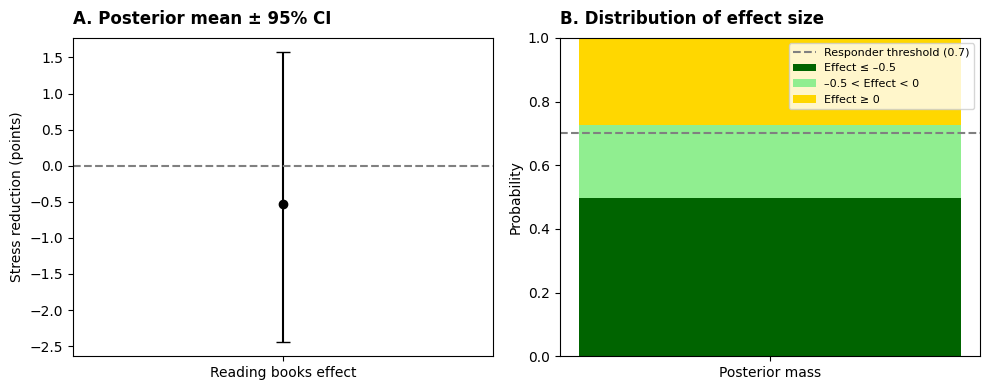

In [30]:
outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
data = (
    outcome_data[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']]
    .dropna()
    .sort_values('current_day_of_study')
    .reset_index(drop=True)
)

y      = data['survey1_question1_response'].values
interv = (data['current_intervention_name'] == "Reading books!").astype(int).values
n      = len(data)

mad = np.median(np.abs(y - np.median(y)))
scale = max(mad, 2.5)


with pm.Model() as model:
    beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)   
    beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)   
    rho      = pm.Uniform('rho',       lower=-1, upper=1)         
    sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)        

    mu = beta0 + beta_int * interv

    pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])

    for t in range(1, n):
        adjustment = rho * (y[t-1] - mu[t-1])
        pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])

    trace = pm.sample(
        draws=500,
        tune=500,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True
    )

summary = az.summary(trace, var_names=['beta_int', 'rho', 'sigma'], hdi_prob=0.95)
print(summary)

beta_samples = trace.posterior['beta_int'].values.flatten()

p_le_neg05 = (beta_samples <= -0.5).mean()
p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
p_ge0      = (beta_samples >= 0).mean()

print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

mean_beta = summary.loc['beta_int', 'mean']
hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

ax = axes[0]
ax.errorbar(0, mean_beta,
            yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
            fmt='o', capsize=5, color='black')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xticks([0])
ax.set_xticklabels(['Reading books effect'])
ax.set_ylabel('Stress reduction (points)')
ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

ax = axes[1]
ax.bar(0, p_le_neg05, width=0.6, color='darkgreen',  label='Effect ≤ –0.5')
ax.bar(0, p_between,  width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < Effect < 0')
ax.bar(0, p_ge0,      width=0.6, bottom=p_le_neg05+p_between, color='gold', label='Effect ≥ 0')
ax.axhline(0.7, color='gray', linestyle='--', label='Responder threshold (0.7)')
ax.set_xticks([0])
ax.set_xticklabels(['Posterior mass'])
ax.set_ylim(0, 1)
ax.set_ylabel('Probability')
ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

#### Bayesian AR(1) Regression with Consecutive‐Day Adjustment

Only intervention:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 92 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.528  0.660    -1.874      0.736      0.025    0.022     691.0   
rho      -0.057  0.334    -0.693      0.646      0.016    0.014     417.0   
sigma     1.799  0.304     1.230      2.357      0.012    0.010     567.0   

          ess_tail  r_hat  
beta_int     611.0   1.00  
rho          289.0   1.00  
sigma        514.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 52.30%
P(beta_int ≤ –0.5) = 52.30%
P(–0.5 < beta_int < 0) = 27.70%
P(beta_int ≥ 0) = 20.00%


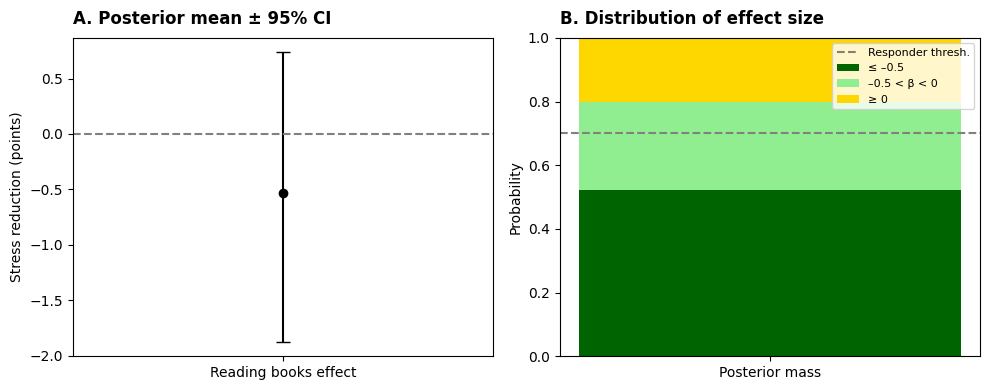


Intervention + fac1:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 174 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.453  0.576    -1.634      0.589      0.025    0.017     548.0   
rho      -0.134  0.320    -0.792      0.450      0.014    0.011     497.0   
sigma     1.440  0.279     0.989      2.017      0.011    0.011     650.0   
beta_f1   0.619  0.207     0.217      1.035      0.010    0.007     424.0   

          ess_tail  r_hat  
beta_int     465.0    1.0  
rho          512.0    1.0  
sigma        557.0    1.0  
beta_f1      334.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 45.40%
P(beta_int ≤ –0.5) = 45.40%
P(–0.5 < beta_int < 0) = 32.60%
P(beta_int ≥ 0) = 22.00%


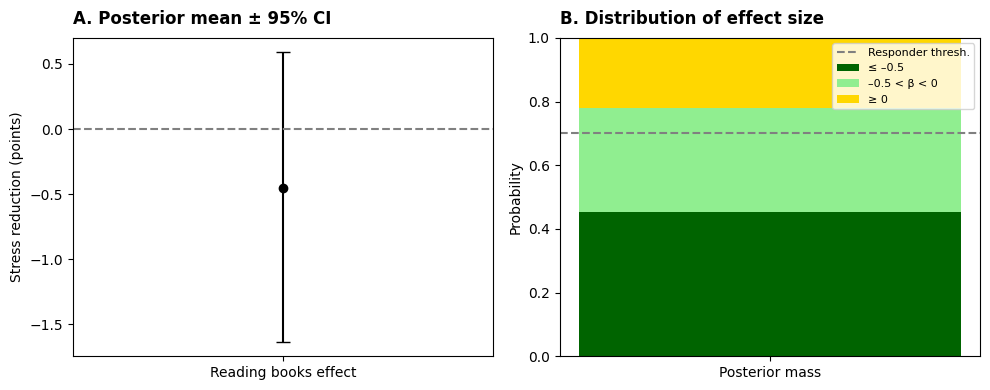


Intervention + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 174 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.428  0.518    -1.405      0.620      0.021    0.018     595.0   
rho      -0.004  0.338    -0.677      0.687      0.012    0.014     759.0   
sigma     1.079  0.220     0.681      1.496      0.009    0.008     596.0   
beta_f2   0.857  0.158     0.524      1.142      0.007    0.005     475.0   

          ess_tail  r_hat  
beta_int     474.0   1.00  
rho          488.0   1.00  
sigma        769.0   1.00  
beta_f2      527.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 44.50%
P(beta_int ≤ –0.5) = 44.50%
P(–0.5 < beta_int < 0) = 35.40%
P(beta_int ≥ 0) = 20.10%


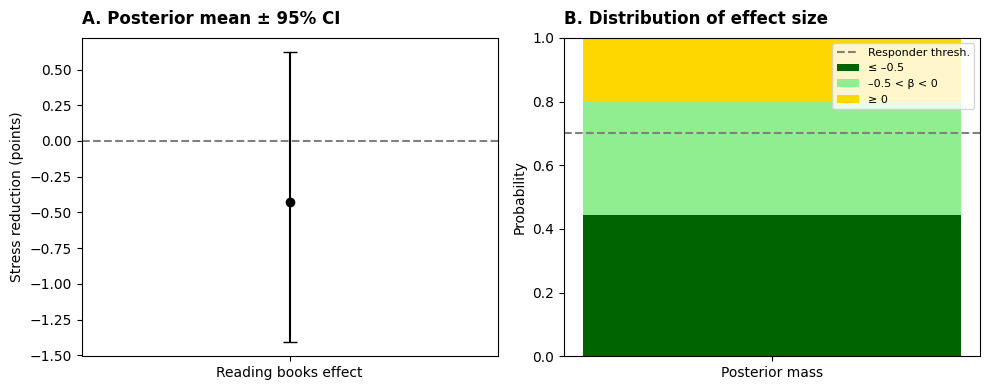


Intervention + fac1 + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 221 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.384  0.526    -1.386      0.651      0.022    0.017     573.0   
rho      -0.018  0.375    -0.779      0.712      0.015    0.014     631.0   
sigma     1.118  0.241     0.717      1.589      0.012    0.011     387.0   
beta_f1  -0.069  0.231    -0.463      0.474      0.010    0.008     544.0   
beta_f2   0.927  0.271     0.376      1.412      0.013    0.011     422.0   

          ess_tail  r_hat  
beta_int     483.0   1.00  
rho          461.0   1.00  
sigma        471.0   1.00  
beta_f1      540.0   1.01  
beta_f2      330.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 40.70%
P(beta_int ≤ –0.5) = 40.70%
P(–0.5 < beta_int < 0) = 37.90%
P(beta_int ≥ 0) = 21.40%


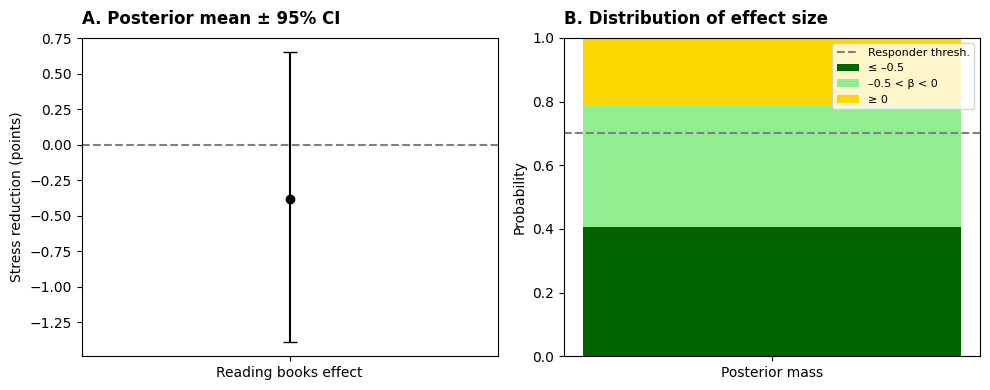

(Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
 beta_int -0.384  0.526    -1.386      0.651      0.022    0.017     573.0   
 rho      -0.018  0.375    -0.779      0.712      0.015    0.014     631.0   
 sigma     1.118  0.241     0.717      1.589      0.012    0.011     387.0   
 beta_f1  -0.069  0.231    -0.463      0.474      0.010    0.008     544.0   
 beta_f2   0.927  0.271     0.376      1.412      0.013    0.011     422.0   
 
           ess_tail  r_hat  
 beta_int     483.0   1.00  
 rho          461.0   1.00  
 sigma        471.0   1.00  
 beta_f1      540.0   1.01  
 beta_f2      330.0   1.01  )

In [31]:
def run_ar1_model(df_mea, use_fac1=False, use_fac2=False):
    days_full = pd.DataFrame({'current_day_of_study': np.arange(0, 16)})

    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome'][
        ['current_day_of_study',
         'survey1_question1_response',   
         'current_intervention_name']
    ]
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators'][
        ['current_day_of_study',
         'survey2_question1_response',   
         'survey2_question2_response']   
    ]

    data = (
        days_full
        .merge(outcome_data,  on='current_day_of_study', how='left')
        .merge(mediator_data, on='current_day_of_study', how='left')
        .sort_values('current_day_of_study')
        .reset_index(drop=True)
    )

    days   = data['current_day_of_study'].values
    y      = data['survey1_question1_response'].values.astype(float)  
    n      = len(y)  

    interv = (data['current_intervention_name'] == "Reading books!").astype(float).fillna(0).values

    if use_fac1:
        fac1 = data['survey2_question1_response'].values.astype(float)
        fac1 = np.nan_to_num(fac1, nan=0.0)
    else:
        fac1 = np.zeros_like(days, dtype=float)

    if use_fac2:
        fac2 = data['survey2_question2_response'].values.astype(float)
        fac2 = np.nan_to_num(fac2, nan=0.0)
    else:
        fac2 = np.zeros_like(days, dtype=float)

    obs_mask = ~np.isnan(y)
    consec   = np.zeros(n, dtype=float)
    consec[1:] = (obs_mask[1:] & obs_mask[:-1]).astype(float)

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if use_fac1:
            beta_f1  = pm.Normal('beta_f1',  mu=0, sigma=10)
        if use_fac2:
            beta_f2  = pm.Normal('beta_f2',  mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if use_fac1:
            mu = mu + beta_f1 * fac1
        if use_fac2:
            mu = mu + beta_f2 * fac2

        y_tt      = pt.constant(y)            
        mu_tt     = mu
        consec_tt = pt.constant(consec)

        def ar1_step(y_prev, mu_prev, mu_curr, consec_prev, rho):
            ar_term = pt.switch(pt.eq(consec_prev, 1.0), rho * (y_prev - mu_prev), 0.0)
            return mu_curr + ar_term

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu_tt[:-1], mu_tt[1:], consec_tt[:-1]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu_tt[0]], y_pred_scan], axis=0)

        y_obs_masked = np.ma.masked_invalid(y)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_obs_masked)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if use_fac1:
        var_names.append('beta_f1')
    if use_fac2:
        var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4),
                             gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Reading books effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left',
                 pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold',       label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left',
                 pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

    return trace, summary

print("Only intervention:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=False)

print("\nIntervention + fac1:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=False)

print("\nIntervention + fac2:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=True)

print("\nIntervention + fac1 + fac2:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=True)


#### Bayesian AR(1) Model of Daily Stress Response to Reading Books and Mediators - Mean Imputation Method

In [32]:
imputed_data_o = df_mea[df_mea['measurement_name'] == 'Outcome'].copy()
imputed_data_o['current_day_of_study'] = imputed_data_o['current_day_of_study'].astype(int)

days = pd.DataFrame({'current_day_of_study': range(0, 16)})

imputed_complete_o = days.merge(
    imputed_data_o, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)

imputed_data_m = df_mea[df_mea['measurement_name'] == 'Mediators'].copy()
imputed_data_m['current_day_of_study'] = imputed_data_m['current_day_of_study'].astype(int)

imputed_complete_m = days.merge(
    imputed_data_m, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_m['measurement_name'].fillna('Mediators', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_22192\224566006.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_22192\224566006.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [33]:
df_o = imputed_complete_o.copy()
df_m = imputed_complete_m.copy()
pattern = (
    ['A'] * 4 +
    ['B'] * 8 +
    ['A'] * 4 
)
txt = {
    'A': "Reading books!",
    'B': "Not reading books!"
}

df_unique_o = (
    df_o
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                   
)

df_fill_o = (
    df_unique_o
    .reindex(range(0, 16))                    
    .reset_index()                            
)

mask_o = df_fill_o['current_intervention_name'].isna()
df_fill_o.loc[mask_o, 'current_intervention_name'] = (
    df_fill_o.loc[mask_o, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)
df_unique_m = (
    df_m
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                   
)

df_fill_m = (
    df_unique_m
    .reindex(range(0, 16))                     
    .reset_index()                             
)

mask_m = df_fill_m['current_intervention_name'].isna()
df_fill_m.loc[mask_m, 'current_intervention_name'] = (
    df_fill_m.loc[mask_m, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

In [34]:
df_mean_imp_o = df_fill_o.copy()
df_mean_imp_m = df_fill_m.copy()

df_mean_imp_o['survey1_question1_response'] = (
    df_mean_imp_o
    .groupby('current_intervention_name')['survey1_question1_response']
    .transform(lambda grp: grp.fillna(grp.mean()))
)
cols_to_impute = [
    'survey2_question1_response',
    'survey2_question2_response'
]

for col in cols_to_impute:
    df_mean_imp_m[col] = (
        df_mean_imp_m
        .groupby('current_intervention_name')[col]
        .transform(lambda grp: grp.fillna(grp.mean()))
    )

In [35]:

def run_model(fac_cols, beta_names):
    out = df_mean_imp_o.copy()
    med = df_mean_imp_m.copy()
    data = (
        pd.merge(
            out[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']],
            med[['current_day_of_study'] + fac_cols] if fac_cols else out[['current_day_of_study']],
            on='current_day_of_study',
            how='inner'
        ).dropna().sort_values('current_day_of_study').reset_index(drop=True)
    )
    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Reading books!").astype(int).values
    n = len(data)
    fac_arrays = [data[col].values for col in fac_cols] if fac_cols else []

    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        betas = [pm.Normal(beta_name, mu=0, sigma=1) for beta_name in beta_names]
        rho = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        mu = beta0 + beta_int * interv
        for beta, fac in zip(betas, fac_arrays):
            mu += beta * fac
        pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])
        for t in range(1, n):
            adjustment = rho * (y[t-1] - mu[t-1])
            pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])
        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9, return_inferencedata=True)
    summary = az.summary(trace, var_names=['beta_int'] + beta_names + ['rho', 'sigma'], hdi_prob=0.95)
    print(summary)
    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()
    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")
    prob = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(Stress reduction of reading books ≥ 0.5) = {prob:.2%}\n")

print("Model result with neither fac1 nor fac2 (intervention only):")
run_model([], [])

print("Model result with only fac1:")
run_model(['survey2_question1_response'], ['beta_f1'])

print("Model result with only fac2:")
run_model(['survey2_question2_response'], ['beta_f2'])

print("Model result with both fac1 and fac2:")
run_model(['survey2_question1_response', 'survey2_question2_response'], ['beta_f1', 'beta_f2'])

Model result with neither fac1 nor fac2 (intervention only):


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 85 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.547  0.665    -1.905      0.772      0.025    0.022     698.0   
rho      -0.029  0.313    -0.639      0.540      0.015    0.020     513.0   
sigma     1.765  0.295     1.293      2.400      0.014    0.014     468.0   

          ess_tail  r_hat  
beta_int     537.0    1.0  
rho          183.0    1.0  
sigma        501.0    1.0  
P(beta_int ≤ –0.5) = 53.70%
P(–0.5 < beta_int < 0) = 27.30%
P(beta_int ≥ 0) = 19.00%
P(Stress reduction of reading books ≥ 0.5) = 53.70%

Model result with only fac1:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 169 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.348  0.689    -1.686      0.986      0.030    0.022     543.0   
beta_f1   0.518  0.219     0.100      0.942      0.010    0.009     483.0   
rho       0.055  0.300    -0.580      0.623      0.014    0.013     495.0   
sigma     1.589  0.268     1.084      2.102      0.010    0.012     768.0   

          ess_tail  r_hat  
beta_int     630.0   1.00  
beta_f1      514.0   1.00  
rho          443.0   1.01  
sigma        601.0   1.00  
P(beta_int ≤ –0.5) = 40.00%
P(–0.5 < beta_int < 0) = 30.70%
P(beta_int ≥ 0) = 29.30%
P(Stress reduction of reading books ≥ 0.5) = 40.00%

Model result with only fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 163 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.121  0.634    -1.410      1.062      0.032    0.028     400.0   
beta_f2   0.920  0.227     0.473      1.355      0.012    0.008     351.0   
rho       0.207  0.302    -0.327      0.880      0.014    0.012     486.0   
sigma     1.310  0.251     0.862      1.781      0.012    0.011     479.0   

          ess_tail  r_hat  
beta_int     424.0   1.01  
beta_f2      503.0   1.01  
rho          324.0   1.00  
sigma        510.0   1.01  
P(beta_int ≤ –0.5) = 25.10%
P(–0.5 < beta_int < 0) = 33.90%
P(beta_int ≥ 0) = 41.00%
P(Stress reduction of reading books ≥ 0.5) = 25.10%

Model result with both fac1 and fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 225 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.099  0.652    -1.350      1.158      0.027    0.021     600.0   
beta_f1   0.032  0.271    -0.490      0.545      0.012    0.010     531.0   
beta_f2   0.899  0.324     0.276      1.585      0.014    0.012     559.0   
rho       0.170  0.316    -0.388      0.834      0.015    0.010     420.0   
sigma     1.344  0.249     0.908      1.843      0.011    0.010     540.0   

          ess_tail  r_hat  
beta_int     610.0   1.01  
beta_f1      432.0   1.01  
beta_f2      497.0   1.00  
rho          461.0   1.00  
sigma        618.0   1.01  
P(beta_int ≤ –0.5) = 26.70%
P(–0.5 < beta_int < 0) = 28.10%
P(beta_int ≥ 0) = 45.20%
P(Stress reduction of reading books ≥ 0.5) = 26.70%



#### Bayesian AR(1) Model of Daily Stress Response to Reading Books and Mediators - Latent Missing Method

In [36]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    all_days = pd.DataFrame({'current_day_of_study': np.arange(0, 16)})
    outcome_data = pd.merge(all_days, outcome_data[merge_cols], on='current_day_of_study', how='left')
    if mediator_cols:
        mediator_data = pd.merge(all_days,
                                  mediator_data[['current_day_of_study'] + mediator_cols],
                                  on='current_day_of_study', how='left')
    else:
        mediator_data = all_days.copy()

    data = (pd.merge(outcome_data, mediator_data, on='current_day_of_study', how='left')
              .sort_values('current_day_of_study')
              .reset_index(drop=True))

    y_obs_raw = data['survey1_question1_response'].values
    y_obs = y_obs_raw.astype(float)
    interv = (data['current_intervention_name'] == "Reading books!").astype(float).fillna(0.0)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None
    n = len(y_obs)

    nan_idx = np.isnan(y_obs)
    obs_idx = ~nan_idx
    missing_idx = np.where(nan_idx)[0].tolist()

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho   = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * pt.as_tensor_variable(np.nan_to_num(fac1, nan=0.0))
        if include_fac2:
            mu = mu + beta_f2 * pt.as_tensor_variable(np.nan_to_num(fac2, nan=0.0))

        y_latent = pm.Normal('y_latent', mu=0, sigma=10, shape=len(missing_idx))

        y_filled = pt.zeros(n)
        y_filled = pt.set_subtensor(y_filled[missing_idx], y_latent)
        y_filled = pt.set_subtensor(y_filled[obs_idx], y_obs[obs_idx])

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_filled[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1
        )
        y_pred = pt.concatenate([mu[:1], y_pred_scan], axis=0)

        pm.Normal('y_obs',
                  mu=y_pred[obs_idx],
                  sigma=sigma,
                  observed=y_obs[obs_idx])

        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9,
                          return_inferencedata=True)

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1: var_names.append('beta_f1')
    if include_fac2: var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 113 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.490  0.719    -2.054      0.795      0.037    0.040     417.0   
rho      -0.014  0.269    -0.523      0.555      0.013    0.011     469.0   
sigma     1.797  0.316     1.234      2.378      0.015    0.009     412.0   

          ess_tail  r_hat  
beta_int     351.0   1.01  
rho          402.0   1.01  
sigma        729.0   1.00  
P(beta_int ≤ –0.5) = 50.50%
P(–0.5 < beta_int < 0) = 27.10%
P(beta_int ≥ 0) = 22.40%
Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 176 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.418  0.563    -1.410      0.841      0.022    0.022     680.0   
rho      -0.075  0.246    -0.582      0.386      0.013    0.012     412.0   
sigma     1.462  0.281     0.986      2.040      0.012    0.012     642.0   
beta_f1   0.616  0.206     0.199      0.999      0.011    0.009     385.0   

          ess_tail  r_hat  
beta_int     566.0    1.0  
rho          384.0    1.0  
sigma        526.0    1.0  
beta_f1      568.0    1.0  
P(beta_int ≤ –0.5) = 42.90%
P(–0.5 < beta_int < 0) = 35.60%
P(beta_int ≥ 0) = 21.50%
Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 185 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.507  0.523    -1.577      0.478      0.021    0.017     629.0   
rho       0.070  0.288    -0.476      0.771      0.020    0.018     227.0   
sigma     1.067  0.226     0.658      1.497      0.010    0.009     574.0   
beta_f2   0.889  0.176     0.520      1.214      0.007    0.006     584.0   

          ess_tail  r_hat  
beta_int     591.0   1.01  
rho          221.0   1.01  
sigma        631.0   1.00  
beta_f2      580.0   1.00  
P(beta_int ≤ –0.5) = 48.50%
P(–0.5 < beta_int < 0) = 35.40%
P(beta_int ≥ 0) = 16.10%
Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 275 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.452  0.534    -1.478      0.666      0.024    0.022     517.0   
rho       0.041  0.266    -0.532      0.570      0.014    0.017     397.0   
sigma     1.098  0.238     0.677      1.541      0.011    0.007     503.0   
beta_f1  -0.060  0.242    -0.565      0.358      0.011    0.009     477.0   
beta_f2   0.950  0.277     0.378      1.468      0.012    0.010     528.0   

          ess_tail  r_hat  
beta_int     433.0   1.01  
rho          298.0   1.01  
sigma        589.0   1.00  
beta_f1      395.0   1.00  
beta_f2      504.0   1.00  
P(beta_int ≤ –0.5) = 43.90%
P(–0.5 < beta_int < 0) = 37.10%
P(beta_int ≥ 0) = 19.00%
